In [68]:
import pandas as pd
import numpy as np 
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
import pandas as pd
final_df_3 = pd.read_csv('../Capstone/final_df_3.csv')

In [70]:
final_df_3.drop(['Unnamed: 0'], axis=1, inplace=True)

In [71]:
final_df_3 = pd.get_dummies(final_df_3, columns=['team_x', 'team_y'])

In [72]:
final_df_3.head(1)

,gsis_id,winner,score_x,score_y,week,day_of_week,defense_ffum_x,defense_frec_x,defense_frec_tds_x,defense_int_x,...,team_y_OAK,team_y_PHI,team_y_PIT,team_y_SD,team_y_SEA,team_y_SF,team_y_STL,team_y_TB,team_y_TEN,team_y_WAS
0,2009091000,1,13,10,1,4,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#  Train/Test Split

In [73]:
from sklearn.cross_validation import train_test_split

y = final_df_3['winner']
X = final_df_3.iloc[:, 4:]

In [74]:
X.head(1)

,week,day_of_week,defense_ffum_x,defense_frec_x,defense_frec_tds_x,defense_int_x,defense_int_tds_x,defense_qbhit_x,defense_safe_x,defense_sk_x,...,team_y_OAK,team_y_PHI,team_y_PIT,team_y_SD,team_y_SEA,team_y_SF,team_y_STL,team_y_TB,team_y_TEN,team_y_WAS
0,1,4,1,1,0,1,0,3,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [75]:
y.value_counts()

1    1057
0     803
Name: winner, dtype: int64

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [77]:
print y_train.shape
print X_train.shape

(1302,)
(1302, 140)


# Logistic Regression

In [78]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [79]:
model = logreg.fit(X_train,y_train)

In [80]:
model.score(X_train, y_train)

0.96697388632872505

In [81]:
from sklearn import metrics

predicted = model.predict(X_test)
prob = model.predict_proba(X_test)

lr_accuracy_score = metrics.accuracy_score(y_test, predicted)
lr_roc_score = metrics.roc_auc_score(y_test, prob[:, 1])

print lr_accuracy_score
print lr_roc_score


0.935483870968
0.986275650518


In [82]:
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

[[212  20]
 [ 16 310]]
             precision    recall  f1-score   support

          0       0.93      0.91      0.92       232
          1       0.94      0.95      0.95       326

avg / total       0.94      0.94      0.94       558



In [83]:
from sklearn.cross_validation import cross_val_score
lr_cv_score = cross_val_score(LogisticRegression(), X_train, y_train, scoring='accuracy', cv=5).mean()

In [84]:
logreg_params = {
    'penalty':['l1','l2']
}

In [85]:
from sklearn.grid_search import GridSearchCV
logreg_gs = GridSearchCV(LogisticRegression(), logreg_params, cv=5, verbose=1)

In [86]:
logreg_gs.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2']}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=1)

In [87]:
logreg_best = logreg_gs.best_estimator_
print logreg_best
print logreg_gs.best_params_
print logreg_gs.best_score_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
{'penalty': 'l2'}
0.927035330261


In [260]:
lr_gs_predicted = logreg_gs.predict(X_test)

In [261]:
print metrics.confusion_matrix(y_test, lr_gs_predicted)
print metrics.classification_report(y_test, lr_gs_predicted)

[[212  20]
 [ 16 310]]
             precision    recall  f1-score   support

          0       0.93      0.91      0.92       232
          1       0.94      0.95      0.95       326

avg / total       0.94      0.94      0.94       558



# KNN Classifier

In [133]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [136]:
knn_cv_score = cross_val_score(knn, X_train, y_train, cv=5).mean()

0.69361127422196123

In [134]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [144]:
knn_predicted = knn.predict(X_test)
knn_prob = knn.predict_proba(X_test)

knn_accuracy_score = metrics.accuracy_score(y_test, knn_predicted)
knn_roc_score = metrics.roc_auc_score(y_test, knn_prob[:, 1])

print knn_accuracy_score
print knn_roc_score
print metrics.confusion_matrix(y_test, knn_predicted)
print metrics.classification_report(y_test, knn_predicted)

0.681003584229
0.714657816797
[[142  90]
 [ 88 238]]
             precision    recall  f1-score   support

          0       0.62      0.61      0.61       232
          1       0.73      0.73      0.73       326

avg / total       0.68      0.68      0.68       558



In [141]:
knn_params = {
    'n_neighbors':range(1,50),
    'weights':['uniform','distance']
}
knn_gs = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, verbose=1)

In [142]:
knn_gs.fit(X_train, y_train)

Fitting 5 folds for each of 98 candidates, totalling 490 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    9.8s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:   24.3s
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:   26.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [262]:
knn_best = knn_gs.best_estimator_
print knn_best
print knn_gs.best_params_
print knn_gs.best_score_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=37, p=2,
           weights='uniform')
{'n_neighbors': 37, 'weights': 'uniform'}
0.73886328725


In [263]:
knn_gs_predicted = knn_gs.predict(X_test)
print metrics.confusion_matrix(y_test, knn_gs_predicted)
print metrics.classification_report(y_test, knn_gs_predicted)

[[137  95]
 [ 67 259]]
             precision    recall  f1-score   support

          0       0.67      0.59      0.63       232
          1       0.73      0.79      0.76       326

avg / total       0.71      0.71      0.71       558



In [152]:
knn_predicted = knn_gs.predict(X_test)
knn_prob = knn_gs.predict_proba(X_test)

knn_accuracy_score = metrics.accuracy_score(y_test, knn_predicted)
knn_roc_score = metrics.roc_auc_score(y_test, knn_prob[:, 1])

print knn_accuracy_score
print knn_roc_score

0.709677419355
0.790650782737


# Decision Tree

In [235]:
from sklearn.tree import DecisionTreeClassifier
from ipywidgets import *
from IPython.display import display

dtc = DecisionTreeClassifier()

In [236]:
dt_cv_score = cross_val_score(dtc, X_train, y_train, cv=5).mean()
print dt_cv_score

0.817222548444


In [237]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [238]:
dtc_predicted = dtc.predict(X_test)
dtc_prob = dtc.predict_proba(X_test)

print metrics.accuracy_score(y_test, dtc_predicted)
print metrics.roc_auc_score(y_test, dtc_prob[:, 1])
print metrics.confusion_matrix(y_test, dtc_predicted)
print metrics.classification_report(y_test, dtc_predicted)

0.838709677419
0.832755976306
[[185  47]
 [ 43 283]]
             precision    recall  f1-score   support

          0       0.81      0.80      0.80       232
          1       0.86      0.87      0.86       326

avg / total       0.84      0.84      0.84       558



In [91]:
dtc_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10,15,20,25]
}

from sklearn.grid_search import GridSearchCV

dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)

In [92]:
dtc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:    9.3s
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:   10.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25], 'max_depth': [None, 1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [93]:
dtc_best = dtc_gs.best_estimator_
print dtc_best
print dtc_gs.best_params_
print dtc_gs.best_score_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
{'max_features': None, 'min_samples_split': 2, 'max_depth': 4}
0.837173579109


In [240]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

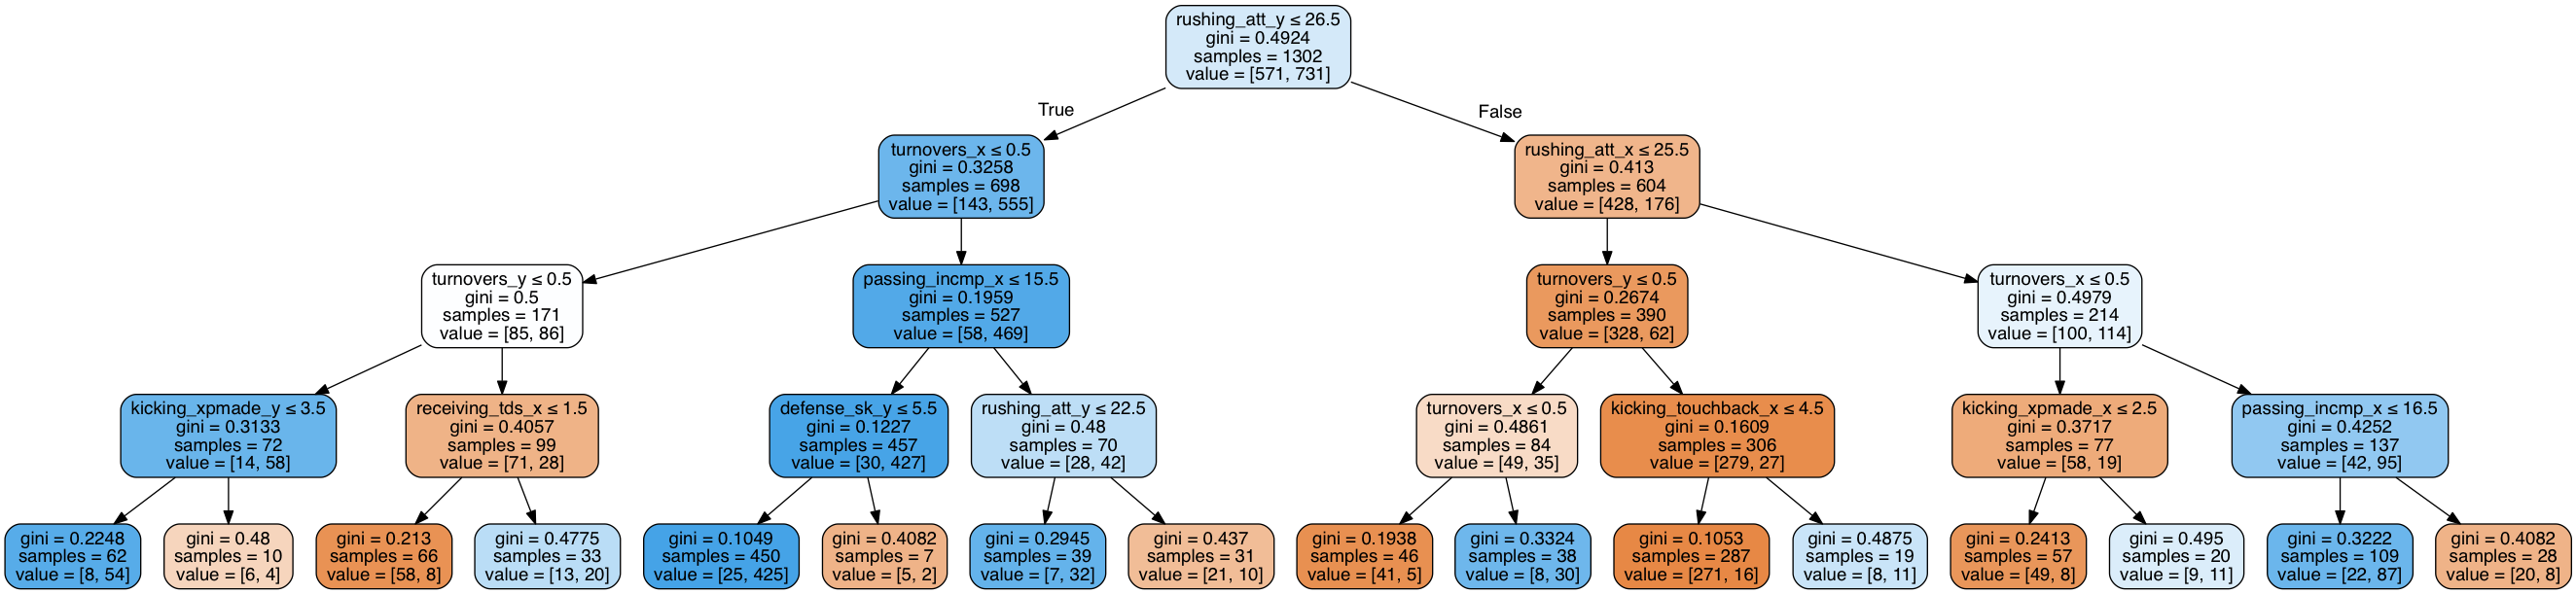

In [241]:
dot_data = StringIO()

export_graphviz(dtc_gs.best_estimator_, out_file=dot_data,  
              filled=True, rounded=True,
              special_characters=True,
              feature_names=X_train.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [94]:
dtfi = pd.DataFrame({
        'feature':X.columns,
        'importance':dtc_best.feature_importances_
    })

dtfi.sort_values('importance', ascending=False, inplace=True)
dtfi.head()

,feature,importance
70,rushing_att_y,0.447599
37,turnovers_x,0.200986
33,rushing_att_x,0.099932
74,turnovers_y,0.095783
19,passing_incmp_x,0.065426


In [95]:
dt_predicted = dtc_gs.predict(X_test)
dt_prob = dtc_gs.predict_proba(X_test)

dt_accuracy_score = metrics.accuracy_score(y_test, dt_predicted)
dt_roc_score = metrics.roc_auc_score(y_test, dt_prob[:, 1])

print dt_accuracy_score
print dt_roc_score

0.844086021505
0.910778506452


In [264]:
dtc_gs_predicted = dtc_gs.predict(X_test)
print metrics.confusion_matrix(y_test, dtc_gs_predicted)
print metrics.classification_report(y_test, dtc_gs_predicted)

[[176  56]
 [ 31 295]]
             precision    recall  f1-score   support

          0       0.85      0.76      0.80       232
          1       0.84      0.90      0.87       326

avg / total       0.84      0.84      0.84       558



# Bagging Decision Tree

In [96]:
from sklearn.ensemble import BaggingClassifier
bdtc = BaggingClassifier(DecisionTreeClassifier())

bt_cv_score = cross_val_score(bdtc, X_train, y_train, cv=5, n_jobs=-1).mean()

In [97]:
params = {'base_estimator__max_depth': [3,5,10,20],
          'max_features': [0.5, 0.7, 1.0],
          'max_samples': [0.5, 0.7, 1.0],
          'n_estimators': [2, 5, 10, 20],
         }

bdt_gs = GridSearchCV(bdtc, params, n_jobs=-1, cv=5)

In [98]:
bdt_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, ...n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [0.5, 0.7, 1.0], 'max_samples': [0.5, 0.7, 1.0], 'base_estimator__max_depth': [3, 5, 10, 20], 'n_estimators': [2, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [99]:
gsbdt_predicted = bdt_gs.predict(X_test)
gsbdt_prob = bdt_gs.predict_proba(X_test)

bt_accuracy_score = metrics.accuracy_score(y_test, gsbdt_predicted)
bt_roc_score = metrics.roc_auc_score(y_test, gsbdt_prob[:, 1])

print bt_accuracy_score
print bt_roc_score

0.888888888889
0.953776179395


In [265]:
bdt_best = bdt_gs.best_estimator_
print bdt_best
print bdt_gs.best_params_
print bdt_gs.best_score_

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=20, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)
{'max_features': 1.0, 'max_samples': 1.0, 'base_estimator__max_depth': 20, 'n_estimators': 20}
0.889400921659


In [266]:
bdt_gs_predicted = bdt_gs.predict(X_test)
print metrics.confusion_matrix(y_test, bdt_gs_predicted)
print metrics.classification_report(y_test, bdt_gs_predicted)

[[201  31]
 [ 31 295]]
             precision    recall  f1-score   support

          0       0.87      0.87      0.87       232
          1       0.90      0.90      0.90       326

avg / total       0.89      0.89      0.89       558



# Extra Tree

In [102]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()

In [103]:
etc.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [104]:
et_cv_score = cross_val_score(etc, X_train, y_train, cv=5).mean()

In [105]:
etc_predicted = etc.predict(X_test)
etc_prob = etc.predict_proba(X_test)

print metrics.accuracy_score(y_test, etc_predicted)
print metrics.roc_auc_score(y_test, etc_prob[:, 1])

0.86917562724
0.955329754601


In [106]:
etc_gs = GridSearchCV(etc, dtc_params, cv=5, verbose=1)

In [107]:
etc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    9.4s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:   17.4s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:   28.1s
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:   43.2s
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:   47.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25], 'max_depth': [None, 1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [108]:
etc_best = etc_gs.best_estimator_
print etc_best
print etc_gs.best_params_
print etc_gs.best_score_

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='sqrt', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=25,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
{'max_features': 'sqrt', 'min_samples_split': 25, 'max_depth': None}
0.89247311828


In [109]:
etfi = pd.DataFrame({
        'feature':X.columns,
        'importance':etc_best.feature_importances_
    })

etfi.sort_values('importance', ascending=False, inplace=True)
etfi.head()

,feature,importance
74,turnovers_y,0.144832
37,turnovers_x,0.102503
13,kicking_xpmade_x,0.062750
5,defense_int_x,0.041506
42,defense_int_y,0.036948


In [110]:
et_predicted = etc_gs.predict(X_test)
et_prob = etc_gs.predict_proba(X_test)

et_accuracy_score = metrics.accuracy_score(y_test, et_predicted)
et_roc_score = metrics.roc_auc_score(y_test, et_prob[:, 1])

print et_accuracy_score
print et_roc_score

0.89605734767
0.959236830971


# Random Forest

In [111]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

In [112]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [113]:
rf_cv_score = cross_val_score(rfc, X_train, y_train, cv=5).mean()

In [114]:
rfc_predicted = rfc.predict(X_test)
rfc_prob = rfc.predict_proba(X_test)

print metrics.accuracy_score(y_test, rfc_predicted)
print metrics.roc_auc_score(y_test, rfc_prob[:, 1])

0.888888888889
0.943939073408


In [267]:
print metrics.confusion_matrix(y_test, rfc_predicted)
print metrics.classification_report(y_test, rfc_predicted)

[[205  27]
 [ 35 291]]
             precision    recall  f1-score   support

          0       0.85      0.88      0.87       232
          1       0.92      0.89      0.90       326

avg / total       0.89      0.89      0.89       558



In [115]:
rfc_gs = GridSearchCV(RandomForestClassifier(), dtc_params, cv=5, verbose=1)

In [116]:
rfc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   11.6s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:   20.3s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:   32.3s
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:   50.4s
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:   55.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25], 'max_depth': [None, 1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [117]:
rfc_best = rfc_gs.best_estimator_
print rfc_best
print rfc_gs.best_params_
print rfc_gs.best_score_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'max_features': None, 'min_samples_split': 2, 'max_depth': None}
0.880952380952


In [118]:
rffi = pd.DataFrame({
        'feature':X.columns,
        'importance':rfc_best.feature_importances_
    })

rffi.sort_values('importance', ascending=False, inplace=True)
rffi.head()

,feature,importance
70,rushing_att_y,0.237414
37,turnovers_x,0.107240
74,turnovers_y,0.085631
33,rushing_att_x,0.074125
13,kicking_xpmade_x,0.063171


In [120]:
rf_predicted = rfc_gs.predict(X_test)
rf_prob = rfc_gs.predict_proba(X_test)

rf_accuracy_score = metrics.accuracy_score(y_test, rf_predicted)
rf_roc_score = metrics.roc_auc_score(y_test, rf_prob[:, 1])

print rf_accuracy_score
print rf_roc_score

0.888888888889
0.946841284113


In [268]:
rfc_gs_predicted = rfc_gs.predict(X_test)
print metrics.confusion_matrix(y_test, rfc_gs_predicted)
print metrics.classification_report(y_test, rfc_gs_predicted)

[[203  29]
 [ 33 293]]
             precision    recall  f1-score   support

          0       0.86      0.88      0.87       232
          1       0.91      0.90      0.90       326

avg / total       0.89      0.89      0.89       558



# Features Importances Comp.

In [122]:
feature_importances = pd.DataFrame(zip(dtc.feature_importances_,
                                       rfc.feature_importances_,
                                       etc.feature_importances_,),
                                       index=X.columns,
                                       columns=['dt_importance',
                                                'rf_importance',
                                                'et_importance'])

In [123]:
feature_importances.sort_values('dt_importance',ascending=False).head()

,dt_importance,rf_importance,et_importance
rushing_att_y,0.277730,0.091611,0.035181
turnovers_x,0.121084,0.065123,0.033644
turnovers_y,0.081769,0.051816,0.040333
rushing_att_x,0.067087,0.034252,0.047941
passing_incmp_x,0.062761,0.057193,0.030123


In [124]:
feature_importances.sort_values('rf_importance',ascending=False).head()

,dt_importance,rf_importance,et_importance
rushing_att_y,0.277730,0.091611,0.035181
turnovers_x,0.121084,0.065123,0.033644
passing_incmp_x,0.062761,0.057193,0.030123
turnovers_y,0.081769,0.051816,0.040333
kicking_xpmade_y,0.011131,0.042878,0.027449


In [125]:
feature_importances.sort_values('et_importance',ascending=False).head()

,dt_importance,rf_importance,et_importance
kicking_xpmade_x,0.012763,0.018840,0.090209
rushing_att_x,0.067087,0.034252,0.047941
turnovers_y,0.081769,0.051816,0.040333
passing_incmp_y,0.017382,0.021805,0.037401
rushing_att_y,0.277730,0.091611,0.035181


In [145]:
best_score = pd.DataFrame(zip(
        [dt_cv_score,
         knn_cv_score,
         rf_cv_score,
         et_cv_score,
         bt_cv_score,
         lr_cv_score],
        [dtc_gs.best_score_,
         knn_gs.best_score_,
         rfc_gs.best_score_,
         etc_gs.best_score_,
         bdt_gs.best_score_, 
         logreg_gs.best_score_], 
        [dt_accuracy_score,
         knn_accuracy_score,
         rf_accuracy_score, 
         et_accuracy_score,
         bt_accuracy_score,
         lr_accuracy_score]),
            index=['Decision Tree',
                   'KNN',
                   'Random Forest',
                   'Extra Tree',
                   'Bagging Trees',
                   'Logistic Regression'],
            columns=['Cross Val Score','Train Score','Test Score'])
best_score

,Cross Val Score,Train Score,Test Score
Decision Tree,0.804157,0.837174,0.844086
KNN,0.693611,0.738863,0.681004
Random Forest,0.860188,0.880952,0.888889
Extra Tree,0.880928,0.892473,0.896057
Bagging Trees,0.867874,0.889401,0.888889
Logistic Regression,0.926988,0.927035,0.935484


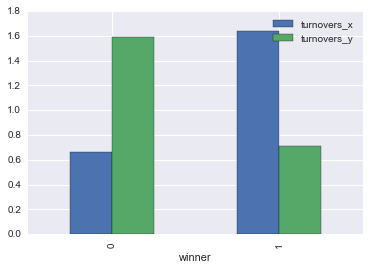

In [127]:
final_df_3.groupby('winner')['turnovers_x','turnovers_y'].mean().plot(kind='bar')

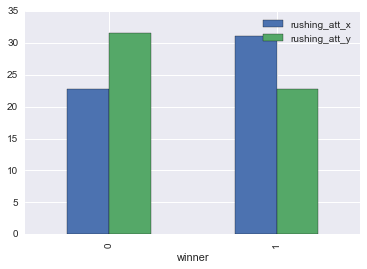

In [128]:
final_df_3.groupby('winner')['rushing_att_x','rushing_att_y'].mean().plot(kind='bar')

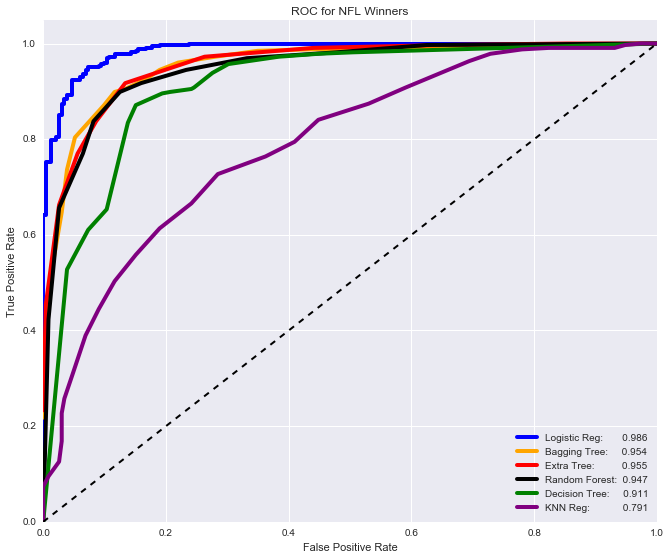

In [234]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(11,9),dpi=640)

fpr, tpr, thresholds = roc_curve(y_test, prob[:,1])
auc1 = auc(fpr,tpr)
plt.plot(fpr, tpr, label="Logistic Reg:       {0}".format(round(auc1,3)),color='blue', linewidth=4)

fpr, tpr, thresholds = roc_curve(y_test, gsbdt_prob[:,1])
auc2 = auc(fpr,tpr)
plt.plot(fpr, tpr,label="Bagging Tree:     {0}".format(round(auc2,3)),color='orange', linewidth=4)

fpr, tpr, thresholds = roc_curve(y_test, etc_prob[:, 1])
auc3 = auc(fpr,tpr)
plt.plot(fpr, tpr,label="Extra Tree:          {0}".format(round(auc3,3)),color='red', linewidth=4)

fpr, tpr, thresholds = roc_curve(y_test, rf_prob[:,1])
auc4 = auc(fpr,tpr)
plt.plot(fpr, tpr,label="Random Forest:  {0}".format(round(auc4,3)),color='black', linewidth=4)

fpr, tpr, thresholds = roc_curve(y_test, dt_prob[:,1])
auc5 = auc(fpr,tpr)
plt.plot(fpr, tpr,label="Decision Tree:     {0}".format(round(auc5,3)),color='green', linewidth=4)

fpr, tpr, thresholds = roc_curve(y_test, knn_prob[:,1])
auc6 = auc(fpr,tpr)
plt.plot(fpr, tpr, label="KNN Reg:            {0}".format(round(auc6,3)),color='purple', linewidth=4)


plt.plot([0, 1], [0, 1], 'k--', lw=2) 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate') 
plt.title('ROC for NFL Winners') 
plt.grid(True)
plt.legend(loc="lower right")
plt.show()